In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

simulate_data = False

if not simulate_data:
    #analysis_name = 'simulated_data_small'
    #analysis_name = 'simulated_data_large'
    analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                            'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
    y_g_vec, y_vec, x_mat, glmm_par, prior_par = load_json_data(json_filename)
    
    K = x_mat.shape[1]
    NG = np.max(y_g_vec) + 1

else:
    # Generate data
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)
    prior_par = logit_glmm.get_default_prior_params(K)
    glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)


print(np.mean(y_vec))

dict_keys(['tau_prior_alpha', 'N', 'K', 'y', 'y_group', 'mu_prior_mean', 'x', 'beta_prior_mean', 'beta_prior_info', 'tau_prior_beta', 'NG', 'mu_prior_info'])
0.213409806931


In [3]:
# Initialize.

if False:
    # Slightly smarter inits would probably improve fit time, but as of now it doesn't
    # seem worth explaining in the paper.
    import pandas as pd
    #print(glmm_par)

    x_t_x = np.matmul(x_mat.transpose(), x_mat)
    x_t_y = np.matmul(x_mat.transpose(), y_vec)
    beta_init = np.linalg.solve(x_t_x, x_t_y)
    #print(beta_init)
    #plt.plot(sp.special.expit(np.matmul(x_mat, beta_init)), y_vec, 'k.')

    df = pd.DataFrame({ 'y_g': y_g_vec, 'y': y_vec}).groupby('y_g')
    #print(df.sum())
    u_init = np.array(df.sum()) / np.array(df.count()['y'])
    #plt.figure()
    print(np.min(y_g_vec))
    #plt.plot(u_init[y_g_vec], y_vec, 'k.')

glmm_par['mu'].mean.set(0.0)
glmm_par['mu'].info.set(1.0)

glmm_par['tau'].shape.set(2.0)
glmm_par['tau'].rate.set(2.0)

glmm_par['beta'].mean.set(np.full(K, 0.0))
#glmm_par['beta'].info.set(np.eye(K))
glmm_par['beta'].info.set(np.ones(K))

glmm_par['u'].mean.set(np.full(NG, 0.0))
glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


In [4]:
# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)
moment_jac = get_moment_jacobian(init_par_vec)


In [5]:
model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
def get_e_log_prior(prior_vec, free_par):
    model.glmm_par.set_free(free_par)
    model.prior_par.set_vector(prior_vec)
    return model.get_e_log_prior()

get_prior_model_grad = autograd.grad(get_e_log_prior, argnum=0)
get_prior_hess = autograd.jacobian(get_prior_model_grad, argnum=1)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)


num_draws =  3
	Function time: 0.015894326998386533
	Grad time: 0.04990489460178651
	Hessian vector product time: 0.10604314259835519
	Prior hess time:  0.07500195503234863


In [6]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_gh_points, gtol=1e-6, maxiter=500):
    model.set_gh_points(num_gh_points)
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': gtol })
    return vb_opt.x

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [7]:
# Optimize.

print('Running Newton Trust Region.')
num_gh_points = 4
vb_time = time.time()
opt_x = tr_optimize(init_par_vec, num_gh_points, gtol=1e-6, maxiter=500)
vb_time = time.time() - vb_time

print('VB time: ', vb_time)
print('Done.')

Running Newton Trust Region.
Iter  0  value:  162354.434209
	x_diff:  inf
Iter  5  value:  38998.7177003
	x_diff:  0.0448425369929
Iter  10  value:  30431.1788754
	x_diff:  1.31959311782
Iter  15  value:  26782.1378198
	x_diff:  0.484492101679
Iter  20  value:  24120.4158785
	x_diff:  1.14842597767
Iter  25  value:  23887.7607754
	x_diff:  0.584701818804
Iter  30  value:  23879.5113995
	x_diff:  1.54801730042e-05
Iter  35  value:  23846.4811303
	x_diff:  2.55090424602e-05
Iter  40  value:  23825.6518432
	x_diff:  1.86358156195e-05
Iter  45  value:  23825.6016448
	x_diff:  0.0130086484227
Optimization terminated successfully.
         Current function value: 23825.601642
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
         Hessian evaluations: 0
VB time:  52.541800022125244
Done.


In [8]:

glmm_par.set_free(opt_x)
if simulate_data:
    print('Fit beta: ', glmm_par['beta'].e())
    print('True beta: ', true_beta)
    
    print('Fit mu: ', glmm_par['mu'].e())
    print('True mu: ', true_mu)
    
    print('Fit tau: ', glmm_par['tau'].e())
    print('True tau: ', true_tau)
    
    plt.plot(true_u, true_u, 'r.')
    plt.plot(true_u, glmm_par['u'].e(), 'k.')
    

VB time:  52.541800022125244
[ 1.44700085  0.03296895  0.11030994 -0.17308099  0.27302143]
GLMM Parameters:
	mu:
mu_mean: [ 2.04149248]
mu_info: [ 4117.03635185]
	tau:
tau_shape: [ 2503.00016505]
tau_rate: [ 3039.81555361]
	beta:
beta_mean:
[ 1.44700085  0.03296895  0.11030994 -0.17308099  0.27302143]
beta_info:
[ 33806.28900287  63229.10973601  72441.81617374  52237.74531174
  54524.85152504]
	u:
u_mean:
[ 3.21159129  3.3788278   3.78659004 ...,  1.84961682  1.57920182
  0.6498244 ]
u_info:
[ 5.21362512  1.67310881  5.3002852  ...,  0.93910507  2.83407442
  1.86566524]


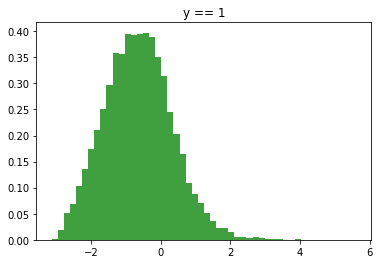

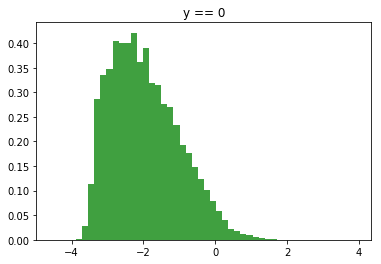

In [9]:
print('VB time: ', vb_time)

import scipy as sp

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
#glmm_par_opt.set_free(init_par_vec)
print(glmm_par_opt['beta'].e())
print(glmm_par_opt)

#plt.plot(glmm_par_opt['u'].e(), glmm_par_opt['u'].var(), 'k.')

e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]

z_mean = e_u + np.matmul(model.x_mat, e_beta)
#plt.plot(sp.special.expit(z_mean), model.y_vec, 'k.')

plt.figure()
plt.hist(z_mean[model.y_vec == 1], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 1')

plt.figure()
plt.hist(z_mean[model.y_vec == 0], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 0')




In [10]:
# In case you want to save without calculating the Hessian, instantiate them here
hess_time = 0.
log_prior_hess = np.array([0.])
elbo_hess = np.array([0.])
moment_jac = np.array([0.])
lrvb_cov = np.array([0.])

In [46]:
# Time using conjugate gradient to get a single row of the moment sensitivity.
import scipy as sp
from scipy.sparse.linalg import LinearOperator

class OptimumHVP(object):
    def __init__(self, glmm_par, opt_x, moment_jac):
        self.verbose = False
        self.print_every = 10
        self.reset_iter()
        self.opt_x = opt_x
        self.moment_jac = moment_jac
        self.lo = LinearOperator(
            (glmm_par.free_size(), glmm_par.free_size()), self.hvp)
        
    def reset_iter(self):
        self.iter = 0
    
    def hvp(self, vec):
        self.iter += 1
        if self.verbose and self.iter % self.print_every == 0:
            print('Iter ', self.iter)
        return objective.fun_free_hvp(self.opt_x, vec)
    
    def get_moment_sensitivity_row(self, moment_row):
        self.reset_iter()
        moment_jac_vec = moment_jac[moment_row, :].flatten()
        cg_res, info = sp.sparse.linalg.cg(self.lo, moment_jac_vec)
        return cg_res, info

moment_row = 0
optimum_hvp = OptimumHVP(glmm_par, opt_x, moment_jac)
optimum_hvp.verbose = True
optimum_hvp.print_every = 20
cg_row_time = time.time()
cg_res, info = optimum_hvp.get_moment_sensitivity_row(0)
cg_row_time = time.time() - cg_row_time

print('CG time: ', cg_row_time)
print('Number of iteratiors: ', optimum_hvp.iter)

print(np.max(np.abs(cg_res - elbo_inv_moment_jac[:, moment_row].flatten())))

Iter  20
Iter  40
Iter  60
Iter  80
CG time:  9.660226345062256
Number of iteratiors:  80
8.59395067444e-07


In [78]:
moment_indices = logit_glmm.MomentWrapper(glmm_par)
moment_indices.moment_par.set_vector(np.arange(moment_indices.moment_par.vector_size()))

global_indices = np.hstack(
    [ moment_indices.moment_par['e_beta'].get(),
      moment_indices.moment_par['e_mu'].get(),
      moment_indices.moment_par['e_tau'].get(),
      moment_indices.moment_par['e_log_tau'].get() ])

optimum_hvp.verbose = False
cg_time = time.time()
global_elbo_inv_moment_jac = np.full((len(global_indices), glmm_par.free_size()), float('nan'))
for moment_row in global_indices:
    print('Moment row ', moment_row, ' of ', len(global_indices))
    cg_row_time = time.time()
    cg_res, info = optimum_hvp.get_moment_sensitivity_row(moment_row)
    cg_row_time = time.time() - cg_row_time
    print('Row time: ', cg_row_time)
    global_elbo_inv_moment_jac[moment_row, :] = cg_res

cg_time = time.time() - cg_time

print('Done.  Time: ', cg_time)

Moment row  0  of  8
Row time:  8.754542589187622
Moment row  1  of  8
Row time:  8.683900594711304
Moment row  2  of  8
Row time:  7.853826999664307
Moment row  3  of  8
Row time:  7.428946018218994
Moment row  4  of  8
Row time:  8.110037088394165
Moment row  5  of  8
Row time:  6.734155178070068
Moment row  6  of  8
Row time:  8.454768896102905
Moment row  7  of  8
Row time:  8.522122144699097
Done.  Time:  64.54982733726501


In [95]:
print(moment_jac.shape)

foo = elbo_inv_moment_jac[:, global_indices].T
print(np.max(np.abs(global_elbo_inv_moment_jac - foo)))

# Get the components of column vector vec orthogonal to and along the rows of matrix x.
def projection_components(x, vec):
    xtx = np.matmul(x, x.T)
    vec_along = np.matmul(x.T, np.linalg.solve(xtx, np.matmul(x, vec)))
    return vec - vec_along, vec_along
    

for i in range(1, 30):
    vec_orth, vec_along = projection_components(moment_jac[0:i, :], moment_jac[i, :])    
    print('i: ', i, ' Orthogonal: ', np.linalg.norm(vec_orth), ' Along: ', np.linalg.norm(vec_along))

# plt.plot(global_elbo_inv_moment_jac.flatten(), foo.flatten(), 'k.')
# plt.plot(foo.flatten(), foo.flatten(), 'r+')

(5008, 10014)
9.68675250044e-06

 i:  1
Orthogonal:  1.0  Along:  0.0

 i:  2
Orthogonal:  1.0  Along:  0.0

 i:  3
Orthogonal:  1.0  Along:  0.0

 i:  4
Orthogonal:  1.0  Along:  0.0

 i:  5
Orthogonal:  1.0  Along:  0.0

 i:  6
Orthogonal:  1.16447090871  Along:  0.0

 i:  7
Orthogonal:  0.000141270655703  Along:  1.41435483303

 i:  8
Orthogonal:  1.0  Along:  0.0

 i:  9
Orthogonal:  1.0  Along:  0.0

 i:  10
Orthogonal:  1.0  Along:  0.0

 i:  11
Orthogonal:  1.0  Along:  0.0

 i:  12
Orthogonal:  1.0  Along:  0.0

 i:  13
Orthogonal:  1.0  Along:  0.0

 i:  14
Orthogonal:  1.0  Along:  0.0

 i:  15
Orthogonal:  1.0  Along:  0.0

 i:  16
Orthogonal:  1.0  Along:  0.0

 i:  17
Orthogonal:  1.0  Along:  0.0

 i:  18
Orthogonal:  1.0  Along:  0.0

 i:  19
Orthogonal:  1.0  Along:  0.0

 i:  20
Orthogonal:  1.0  Along:  0.0

 i:  21
Orthogonal:  1.0  Along:  0.0

 i:  22
Orthogonal:  1.0  Along:  0.0

 i:  23
Orthogonal:  1.0  Along:  0.0

 i:  24
Orthogonal:  1.0  Along:  0.0

 i:  2

In [11]:
# Get the Hessians at the number of draws used for optimization
sparse_model = logit_glmm.SparseModelObjective(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points)
sparse_model.glmm_par.set_free(opt_x)

hess_time = time.time()
print('KL Hessian...\n')
#kl_hess = objective.fun_free_hessian(opt_x)
sparse_vector_hess = \
    sparse_model.get_sparse_vector_hessian(print_every_n=50)
elbo_hess = sparse_model.get_free_hessian(sparse_vector_hess)

print('Log prior Hessian...\n')
log_prior_hess = get_prior_hess(prior_par.get_vector(), opt_x)

moment_jac = get_moment_jacobian(opt_x)

hess_time =  time.time() - hess_time

print('hess_time: %f' % hess_time)

KL Hessian...

Calculating global hessian:
Group 0 of 0
Done.
Calculating local hessian:
Group 0 of 4999
Group 50 of 4999
Group 100 of 4999
Group 150 of 4999
Group 200 of 4999
Group 250 of 4999
Group 300 of 4999
Group 350 of 4999
Group 400 of 4999
Group 450 of 4999
Group 500 of 4999
Group 550 of 4999
Group 600 of 4999
Group 650 of 4999
Group 700 of 4999
Group 750 of 4999
Group 800 of 4999
Group 850 of 4999
Group 900 of 4999
Group 950 of 4999
Group 1000 of 4999
Group 1050 of 4999
Group 1100 of 4999
Group 1150 of 4999
Group 1200 of 4999
Group 1250 of 4999
Group 1300 of 4999
Group 1350 of 4999
Group 1400 of 4999
Group 1450 of 4999
Group 1500 of 4999
Group 1550 of 4999
Group 1600 of 4999
Group 1650 of 4999
Group 1700 of 4999
Group 1750 of 4999
Group 1800 of 4999
Group 1850 of 4999
Group 1900 of 4999
Group 1950 of 4999
Group 2000 of 4999
Group 2050 of 4999
Group 2100 of 4999
Group 2150 of 4999
Group 2200 of 4999
Group 2250 of 4999
Group 2300 of 4999
Group 2350 of 4999
Group 2400 of 4999
Gro

/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Log prior Hessian...

hess_time: 423.743577


In [12]:
print('Solving systems...\n')
inverse_time = time.time()
#lrvb_cov = -1 * np.matmul(moment_jac, np.linalg.solve(elbo_hess, moment_jac.T))
elbo_inv_moment_jac = -1 * sp.sparse.linalg.spsolve(elbo_hess, moment_jac.T)
lrvb_cov = np.matmul(moment_jac, elbo_inv_moment_jac)
vb_prior_sens = np.matmul(log_prior_hess, elbo_inv_moment_jac).T
inverse_time = time.time() - inverse_time
print('Done\n')

print('Inverse time:', inverse_time)

Solving systems...

Done

Inverse time: 178.71107459068298


In [13]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
    pickle_output = open(pickle_output_filename, 'wb')

    # TODO: The sparse matrices are not being saved in a usable form.
    # Unlike with JSON, numpy arrays can be pickled.
    pickle_result_dict = {  'glmm_par_dictval': glmm_par_opt.dictval(),
                            'glmm_par_vector': glmm_par_opt.get_vector(),
                            'glmm_par_free': glmm_par_opt.get_free(),
                            'run_name': run_name,
                            'vb_time': vb_time,
                            'hess_time': hess_time,
                            'inverse_time': inverse_time,
                            'num_gh_points': num_gh_points, 
                            'lrvb_cov': np.squeeze(lrvb_cov),
                            'moment_jac': np.squeeze(moment_jac),
                            'elbo_hess': np.squeeze(elbo_hess),
                            'vb_prior_sens': np.squeeze(vb_prior_sens),
                            'log_prior_hess': np.squeeze(log_prior_hess) }

    # Pickle dictionary using protocol 0.
    pickle.dump(pickle_result_dict, pickle_output)
    pickle_output.close()
    
    print(pickle_output_filename)


print('\n\nDONE.')
    

/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/criteo_subsampled_python_vb_results.pkl


DONE.
